In [1]:
#Importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt
from sklearn import preprocessing

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#To upload file from local system
from google.colab import files
uploaded = files.upload()

Saving ambient_temperature_system_failure.csv to ambient_temperature_system_failure.csv


In [0]:
#Reading file from local syste,
df = pd.read_csv("ambient_temperature_system_failure.csv")

In [4]:
df.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


<Figure size 432x288 with 0 Axes>

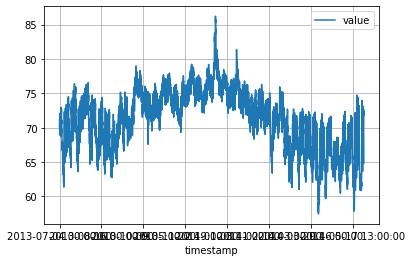

In [5]:
#Visualize the data
plt.figure()
df.plot(x='timestamp', y='value')
plt.grid()
plt.legend()

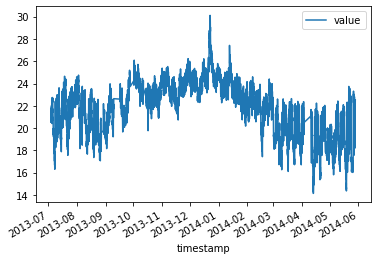

In [6]:
#Changing the type of timestamp column for visualization
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['value'] = (df['value'] - 32) * 5/9
df.plot(x='timestamp', y='value')

In [0]:
#Formating the data into required format
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
# Anomaly estimated population
outliers_fraction = 0.01

In [0]:
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

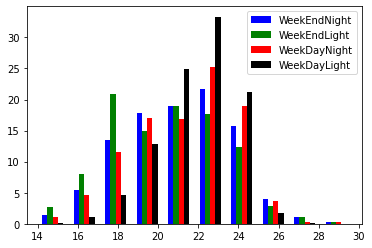

In [9]:
df['categories'] = df['WeekDay']*2 + df['daylight']
a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

#Visualizing the formatted data
fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)
width = (a_bins[1] - a_bins[0])/6
ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')
plt.legend()
plt.show()

In [0]:
#Preparing the data for LSTM model
data_n = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled)
#Important parameters and training/Test size
prediction_time = 1 
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1
#Training data
x_train = data_n[0:-prediction_time-testdatacut].values
y_train = data_n[prediction_time:-testdatacut  ][0].values
#Test data
x_test = data_n[0-testdatacut:-prediction_time].values
y_test = data_n[prediction_time-testdatacut:  ][0].values

In [0]:
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)
#Adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

In [12]:
# Printthe shape
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (6165, 50, 5)
y_train (6165,)
x_test (1000, 50, 5)
y_test (1000,)


In [13]:
#Library for LSTM model
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time

Using TensorFlow backend.


In [14]:
#Building the model
model = Sequential()

model.add(LSTM(input_dim=x_train.shape[-1], output_dim=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 5), units=50)`
  after removing the cwd from sys.path.


compilation time : 0.013941526412963867


In [15]:
model.fit(x_train, y_train, batch_size=3028, nb_epoch=50, validation_split=0.1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 5548 samples, validate on 617 samples
Epoch 1/50
5548/5548 [==============================] - 3s 539us/step - loss: 0.6003 - val_loss: 0.6132
Epoch 2/50
5548/5548 [==============================] - 1s 132us/step - loss: 0.1549 - val_loss: 0.2572
Epoch 3/50
5548/5548 [==============================] - 1s 124us/step - loss: 0.1190 - val_loss: 0.3489
Epoch 4/50
5548/5548 [==============================] - 1s 116us/step - loss: 0.1488 - val_loss: 0.2386
Epoch 5/50
5548/5548 [==============================] - 1s 124us/step - loss: 0.1101 - val_loss: 0.2131
Epoch 6/50
5548/5548 [==============================] - 1s 119us/step - loss: 0.0916 - val_loss: 0.1972
Epoch 7/50
5548/5548 [==============================] - 1s 120us/step - loss: 0.0873 - val_loss: 0.1847
Epoch 8/50
5548/5548 [==============================] - 1s 122us/step - loss: 0.0859 - val_loss: 0.1823
Epoch 9/50
5548/5548 [==============================] - 1s 121us/step - loss: 0.0853 - val_loss: 0.1681
Epoch 10/50
5548/

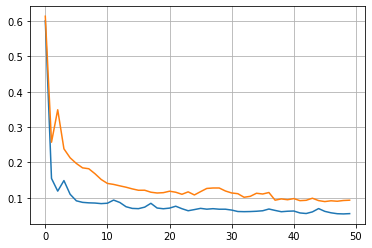

In [16]:
#Visualizing training and validaton loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.grid()
plt.show()

In [0]:
#creating the list of difference between prediction and test data
loaded_model = model
diff=[]
ratio=[]
p = loaded_model.predict(x_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

<Figure size 720x720 with 0 Axes>

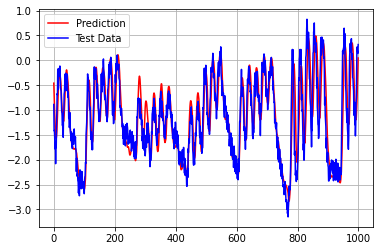

In [18]:
#Plotting the prediction and the reality (for the test data)
plt.figure(figsize=(10,10))
fig, axs = plt.subplots()
axs.plot(p,color='red', label='Prediction')
axs.plot(y_test,color='blue', label='Test Data')
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [19]:
#Pick the most distant prediction/reality data points as anomalies
diff = pd.Series(diff)
number_of_outliers = int(outliers_fraction*len(diff))
threshold = diff.nlargest(number_of_outliers).min()
#Data with anomaly label
test = (diff >= threshold).astype(int)
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))
df['anomaly27'] = complement.append(test, ignore_index='True')
print(df['anomaly27'].value_counts())

0    7257
1      10
Name: anomaly27, dtype: int64


<Figure size 1080x720 with 0 Axes>

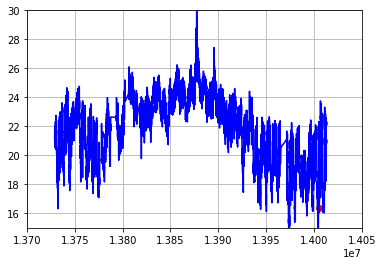

In [20]:
#Visualizing anomalies (Red Dots)
plt.figure(figsize=(15,10))
fig, ax = plt.subplots()
a = df.loc[df['anomaly27'] == 1, ['time_epoch', 'value']] #anomaly
ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.axis([1.370*1e7, 1.405*1e7, 15,30])
plt.grid()
plt.show()